In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import torch
import tqdm

sys.path.append(os.path.dirname(os.getcwd())) 
from source.model_output import SEIRModelOutput, SEIRParams
from source.SEIR_network import SEIRNetworkModel
from source.autoencoder import AESurrogateModel
from source.forecast import SEIRForecaster
import source.plots as plots

from sklearn.metrics import r2_score

In [2]:
ae_model = AESurrogateModel(population=10**5)

beta = 0.5 # transmission rate
gamma = 0.3 # latent period rate
delta = 0.2 # recovery rate
init_inf_frac = 1e-4 # fraction of initially infected

alpha = 0.95
beta = 0.1

initial_params = SEIRParams(0.5, 0.5, gamma, delta, init_inf_frac, tmax=150)
observed_incidence = np.loadtxt('../data/incidence_synthetic_curve.csv')
simulation_incidence = ae_model.simulate(alpha, beta, gamma, delta, init_inf_frac)

In [3]:
forecast_period = 7
forecaster = SEIRForecaster(initial_params=initial_params)


In [4]:
peak_index = observed_incidence.argmax()
onset_period = peak_index - 14 + 1 
peak_period = peak_index - 7 + 1
end_period = peak_index + 1 + 7

forecaster_onset = SEIRForecaster(initial_params=initial_params)
forecaster_peak = SEIRForecaster(initial_params=initial_params)
forecaster_end = SEIRForecaster(initial_params=initial_params)

idata_onset = forecaster_onset.calibrate(ae_model, 
                                         observed_incidence[:onset_period], 
                                         epsilon=500)
idata_peak = forecaster_onset.calibrate(ae_model, 
                                        observed_incidence[:peak_period], 
                                        epsilon=500)
idata_end = forecaster_onset.calibrate(ae_model,
                                       observed_incidence[:end_period], 
                                       epsilon=500)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/Users/andrey/hybrid_surrogate/.env/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/andrey/hybrid_surrogate/.env/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/Users/andrey/hybrid_surrogate/.env/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/Users/andrey/hybrid_surrogate/.env/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

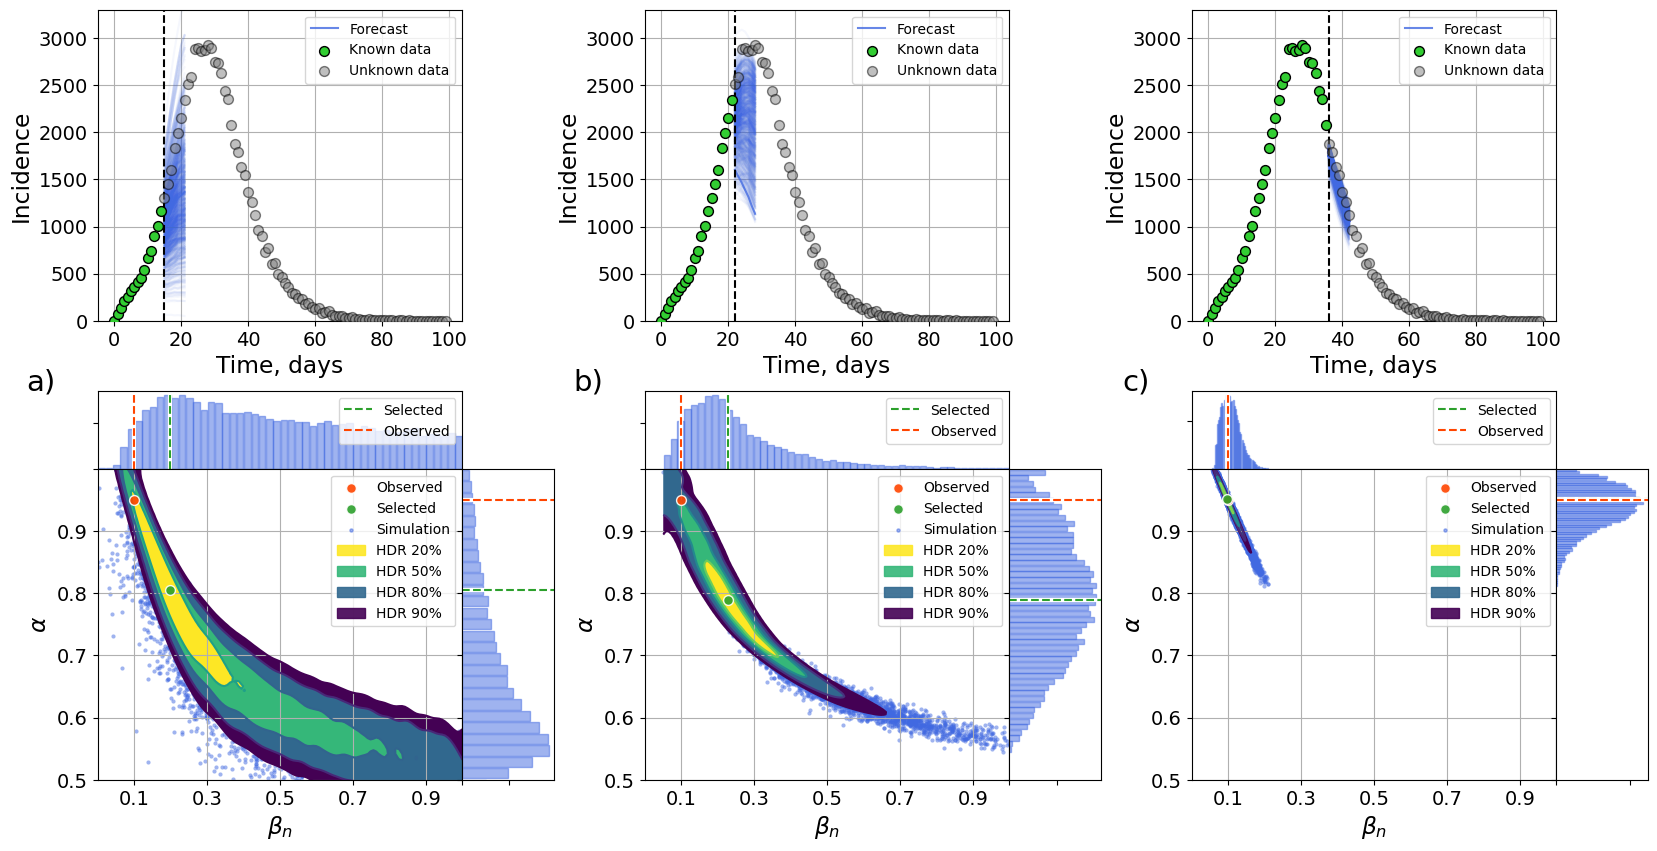

In [5]:
true_alpha = 0.95
true_beta = 0.1
fig = plots.plot_calib_subplots([idata_onset, idata_peak, idata_end], 
                                [observed_incidence[:end] for end in [onset_period, peak_period, end_period]], 
                                true_params_dict={'alpha': true_alpha, 'beta': true_beta},
                                full_data=observed_incidence
                                )
fig.savefig('../figures/ae_ba_network_hdr_subplots.pdf', bbox_inches='tight')
fig.savefig('../figures/ae_ba_network_hdr_abc_subplots.png', bbox_inches='tight', dpi=600)


In [6]:
fig = create_plots_grid_forecast(array_of_params_dict=[params_dict_onset, params_dict_peak, params_dict_end], 
                           array_of_observed=[observed_incidence[:onset_period], 
                                                       observed_incidence[:peak_period],
                                                       observed_incidence[:end_period]],
                           full_data=observed_incidence)
fig.savefig('../figures/ae_ba_network_forercast.pdf', bbox_inches='tight')
fig.savefig('../figures/ae_ba_network_forercast.png', dpi=600, bbox_inches='tight')

NameError: name 'create_plots_grid_forecast' is not defined